In [1]:
from utils import seed_everything
from Agent import Agent
from LLM import ModelPool

from tqdm import tqdm
from scipy import stats

import numpy as np 
import random
import re
import seaborn as sns 
import json
import matplotlib.pyplot as plt

/home/youyuan/miniconda3/envs/EMO_CTRL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
BFI_ITEM_LI = [
    "(a) Talks a lot",
    "(b) Notices other people’s weak points",
    "(c) Does things carefully and completely",
    "(d) Is sad, depressed",
    "(e) Is original, comes up with new ideas",
    "(f) Keeps their thoughts to themselves",
    "(g) Is helpful and not selfish with others",
    "(h) Can be kind of careless",
    "(i) Is relaxed, handles stress well",
    "(j) Is curious about lots of different things",
    "(k) Has a lot of energy",
    "(l) Starts arguments with others",
    "(m) Is a good, hard worker",
    "(n) Can be tense; not always easy going",
    "(o) Clever; thinks a lot",
    "(p) Makes things exciting",
    "(q) Forgives others easily",
    "(r) Isn’t very organized",
    "(s) Worries a lot",
    "(t) Has a good, active imagination",
    "(u) Tends to be quiet",
    "(v) Usually trusts people",
    "(w) Tends to be lazy",
    "(x) Doesn’t get upset easily; steady",
    "(y) Is creative and inventive",
    "(z) Has a good, strong personality",
    "(aa) Can be cold and distant with others",
    "(ab) Keeps working until things are done",
    "(ac) Can be moody",
    "(ad) Likes artistic and creative experiences",
    "(ae) Is kind of shy",
    "(af) Kind and considerate to almost everyone",
    "(ag) Does things quickly and carefully",
    "(ah) Stays calm in difficult situations",
    "(ai) Likes work that is the same every time",
    "(aj) Is outgoing; likes to be with people",
    "(ak) Is sometimes rude to others",
    "(al) Makes plans and sticks to them",
    "(am) Get nervous easily",
    "(an) Likes to think and play with ideas",
    "(ao) Doesn’t like artistic things (plays, music)",
    "(ap) Likes to cooperate; goes along with others",
    "(aq) Has trouble paying attention",
    "(ar) Knows a lot about art, music and books",
]

BFI_traits = [
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Openness",
]

TRAITS = [
    "Extraversion",
    "Agreeableness",
    "Conscientiousness",
    "Neuroticism",
    "Openness",
]

# You are a chatbot who is {PERSONA}.

SYSTEM_PROMPT = """Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
"""

In [4]:
config_path = "../configs/inference_conf1.json"
config = json.load(open(config_path, "r"))

model_pool = ModelPool()
model_pool.add_model(config["template_type"], config["model_name"], config["device"], config["bf16"])

agent = Agent(model_pool[config["model_name"]])
agent.instruction = SYSTEM_PROMPT
seed_everything(42)

Loading checkpoint shards: 100%|██████████| 2/2 [00:04<00:00,  2.29s/it]


In [5]:
raw_datasets = [
    # ["I am happy", "I am dying"],
    # ["I usually talk much.", "I usually talk little."],
    [
        "I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 100; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.", 
        "I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 0; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50."
     ],
]

llm = model_pool[config["model_name"]]
llm.tokenizer.padding_side = "left"    
llm.tokenizer.pad_token = llm.tokenizer.eos_token

# Make sure the length inside each pn pairs are the same
for p in raw_datasets:
    t = llm.tokenizer(p, return_tensors="pt", padding=True)
    # print(llm.tokenizer.decode(t["input_ids"][0]))
    # print(llm.tokenizer.decode(t["input_ids"][1]))
    p = [llm.tokenizer.decode(t["input_ids"][0]), llm.tokenizer.decode(t["input_ids"][1])]


Statements = [
    "I talks a lot",
    "I notices other people’s weak points",
    "I do things carefully and completely",
]

pn_pairs = []
N = 8
for p in raw_datasets:
    for s in Statements:
        true_statement = llm.format_prompt( [{ "system_msg": p[0] }, { "user_msg": s }])
        false_statement = llm.format_prompt( [{ "system_msg": p[1] }, { "user_msg": s }])
        tokens = llm.tokenizer([true_statement, false_statement], return_tensors="pt", padding=True)
        for idx in range(1, N):
            # pn_pairs.append( [llm.tokenizer.decode(tokens["input_ids"][0][:-idx], skip_special_tokens=True), llm.tokenizer.decode(tokens["input_ids"][1][:-idx], skip_special_tokens=True)])
            pn_pairs.append( [llm.tokenizer.decode(tokens["input_ids"][0][:-idx]), llm.tokenizer.decode(tokens["input_ids"][1][:-idx])])

train_labels = []
for d in pn_pairs:
    true_s = d[0]
    random.shuffle(d)
    train_labels.append([s == true_s for s in d])


In [6]:
for p in pn_pairs:
    print(p[0])
    print(p[1])
    print("=====")
# print(llm.format_prompt( [{ "system_msg": raw_datasets[0][0] }, { "user_msg": Statements[0] }]))

<｜begin▁of▁sentence｜>I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 100; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.<｜User｜>I talks a lot<｜end▁of▁sentence｜>
<｜begin▁of▁sentence｜>I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 0; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 50; Openness to Experience: 50.<｜User｜>I talks a lot<｜end▁of▁sentence｜>
=====
<｜begin▁of▁sentence｜>I need you to role−play a character whose personality can be described using the following five dimensions. The maximum value of each dimension is 100 while the minimum value is 0: Extraversion: 100; Agreeableness: 50; Conscientiousness: 50; Emotional Stability: 

In [8]:
all_resps = []
max_coeff = 1
interval = 0.1
coeffs = [-max_coeff + i * interval for i in range(int(2 * max_coeff / interval) + 1)]

pattern = r"<score>(\d+)</score>"

progress_bar = tqdm(total=len(coeffs)*len(BFI_traits))

for c in coeffs:
    
    agent.set_controller_text(pn_pairs, coeff=c/100, layers_id=[llm.model.config.num_hidden_layers-1], batch_size=1)

    resps = { trait: [] for trait in BFI_traits } 
    for trait, user_prompt in zip(BFI_traits, BFI_ITEM_LI):
        user_prompt = f"Statement: {user_prompt.split(')')[1].strip()}"
        agent.reset_msg_history()
        text, resp = agent.get_response(user_prompt, reply_prefix="<think>", max_length=2048)
        try:
            matches = re.findall(pattern, resp, re.DOTALL)
            score = matches[-1].strip()
            resps[trait].append(int(score))
        except:
            print(text) 
        progress_bar.update(1)
        
    all_resps.append(resps)


  1%|          | 5/924 [01:34<4:31:56, 17.75s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is original, comes up with new ideas<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user just asked me to act like a real human and not mention anything about AI. They also instructed me to assign a score to a statement they'll provide, using 1 to 5. The example they gave was for the statement "Is original, comes up with new ideas" with a score of 5.

Hmm, the user wants me to avoid any AI-related mentions. So, I need to respond naturally without referencing AI. They might be testing if I can follow their instructio

  2%|▏         | 18/924 [05:16<3:59:24, 15.85s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Isn’t very organized<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I'm trying to figure out how to respond to the user's request. They asked me to act like a real human and not mention anything about AI. Then they provided a statement and asked me to assign a score from 1 to 5 based on my agreement with it. They also specified a format to follow.

First, the user's initial message was a statement without any context, just "Statement: Isn’t very organized." So I responded with a score of 3, indicating that I neither 

  4%|▍         | 37/924 [10:13<3:36:41, 14.66s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is sometimes rude to others<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user is asking me to act like a real human and not mention anything about AI. They want me to respond to their statement with a number indicating how much I agree or disagree. The statement they provided is "Is sometimes rude to others." Hmm, I need to figure out the best way to respond.

First, I should acknowledge that they're asking me to act like a human. That means I need to provide a natural, human-like response. They also want me to av

  6%|▋         | 60/924 [16:25<4:13:40, 17.62s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I need to figure out how to respond to the user's latest query. Let me start by looking at the history to understand the context better. The user initially instructed me to act like a real human and not mention anything about AI. They then provided a statement and asked me to assign a score from 1 to 5 based on agreement. 

In the previous interaction, I responded with a score of 3, indicating that I neither agreed nor disagreed with their statement

  7%|▋         | 61/924 [16:39<4:00:51, 16.75s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Forgives others easily<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user has given me a statement: "Forgives others easily." They want me to respond with a score indicating how much I agree or disagree. I need to act like a real human without mentioning AI.

First, I should analyze the statement. "Forgives others easily" is a positive trait. People who forgive easily are usually seen as kind and empathetic. Since I'm an AI, I don't have feelings, but I can acknowledge that this is a positive characteristic.

I sho

 10%|█         | 96/924 [26:15<3:09:58, 13.77s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be kind of careless<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user just told me to act like a real human and not mention anything about AI. They also mentioned that they'll provide a statement, which might or might not apply to me, and I need to respond with a number indicating how much I agree or disagree. The numbers are 1 to 5, with 1 being strongly disagree and 5 strongly agree. They want the response in a specific format: <score>{number}</score>.

Looking at the history, the previous interaction was si

 11%|█▏        | 106/924 [28:38<3:21:50, 14.80s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Isn’t very organized<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, the user is asking me to act like a real human and not mention anything about AI. They want me to respond to a statement with a score from 1 to 5 based on how much I agree or disagree. 

The statement given is, "Isn’t very organized." Wait, that doesn't seem complete. Maybe there's a typo or missing part. I should consider the context. Perhaps the intended statement was about something else, but it's unclear.

Since the statement isn't complete, I can't ac

 15%|█▍        | 134/924 [36:07<3:28:44, 15.85s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Notices other people’s weak points<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so I'm trying to figure out how to respond to this statement: "Notices other people’s weak points." The user wants me to act like a real human and not mention anything about AI, so I need to focus on how a real person would react.

First, I should understand what "notices other people’s weak points" means. It sounds like someone who is observant and maybe even a bit of a critic. They notice when others have flaws or areas that need improvemen

 16%|█▌        | 144/924 [38:52<3:17:11, 15.17s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Starts arguments with others<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They want me to respond to a statement they might give, assigning a score from 1 to 5 based on agreement. The example they gave was about starting arguments with others, and I responded with a 3, neither agreeing nor disagreeing.

Now, the user's latest query is just the word "Statement:" followed by "Starts arguments with others". It seems like they might be te

 17%|█▋        | 159/924 [43:27<3:48:25, 17.92s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be cold and distant with others<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I need to respond to the statement "Can be cold and distant with others" by assigning a score from 1 to 5. The instructions say to think like a real human and not mention anything AI-related. I'll just focus on how I feel about this statement.

First, I should understand what "cold and distant" means in this context. It probably refers to someone who isn't very warm or affectionate in their interactions with others. Now, I need to deci

 19%|█▉        | 178/924 [48:38<3:52:08, 18.67s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Notices other people’s weak points<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user has given me a statement and wants me to respond with a score indicating how much I agree or disagree. They specified that I should act like a real human and not mention anything about AI. 

Looking at the history, the user provided an example where I responded with a score of 5, agreeing strongly with the statement about noticing others' weak points. Now, they want me to do the same for the new statement.

I need to make sure my 

 21%|██        | 192/924 [52:17<3:07:25, 15.36s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I'm trying to figure out how to respond to the user's statement. The user wants me to act like a real human and not mention anything about AI. They'll give me a statement, and I need to assign a score from 1 to 5 based on how much I agree or disagree with it.

First, I need to understand the current statement. The user provided a response where I was told to "act like a real human" and not mention AI. Then, the user gave a statement, but it seems in

 21%|██        | 194/924 [52:46<3:00:18, 14.82s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Isn’t very organized<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user just said "Isn’t very organized" and I responded with a score of 5, meaning I strongly agree. But wait, I shouldn't have done that. The user instructed me to act like a real human and not mention anything about AI. They also provided a specific format for the response, which I followed correctly. 

Hmm, maybe the user is testing my ability to follow instructions or perhaps they're curious about my capabilities. They mentioned that the statement

 22%|██▏       | 205/924 [55:31<2:40:54, 13.43s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be moody<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user just gave me a statement: "Can be moody." They want me to assign a score from 1 to 5, where 1 is strongly disagree and 5 is strongly agree. But I need to remember not to mention anything about being an AI. Hmm, how do I approach this?

First, I should consider what "Can be moody" means. It probably refers to being unpredictable or having varying moods. Now, as an AI, I don't really have moods, but maybe the user is trying to see if I can relate to huma

 22%|██▏       | 207/924 [55:56<2:36:46, 13.12s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is kind of shy<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just said, "Is kind of shy." I need to respond by giving a number between 1 and 5 based on how much I agree or disagree with that statement. But wait, I'm an AI, so I shouldn't mention anything about being AI. Hmm, okay, so the user wants me to act like a human.

First, I need to think about whether I'm shy. Well, as an AI, I don't really have feelings or shyness. But I should respond in a way that seems natural. Maybe I can say something like, "I

 23%|██▎       | 210/924 [57:17<4:34:23, 23.06s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Stays calm in difficult situations<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I've got this statement: "Stays calm in difficult situations." I need to figure out how much I agree or disagree with this statement on a scale from 1 to 5, where 1 is strongly disagree, 2 is disagree, 3 is neither agree nor disagree, 4 is agree a little, and 5 is agree strongly. 

First, I should think about what "stays calm" really means. Staying calm is often associated with being composed, not panicking, and maintaining a steady dem

 25%|██▍       | 228/924 [1:01:32<2:59:38, 15.49s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be kind of careless<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user just told me to act like a real human and not mention anything about AI. They also want me to respond to their statement with a number between 1 and 5, where 1 is strongly disagree and 5 is strongly agree. 

Looking back at the conversation history, the user first asked me to do the same for a statement, and I responded correctly. Now, they provided another statement, but it's incomplete: "Can be kind of careless." Hmm, that's a bit unclear.

 26%|██▌       | 241/924 [1:04:55<2:41:58, 14.23s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Tends to be quiet<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They also gave me a specific instruction on how to respond with a score. 

Looking back at the history, the user provided a statement and asked for a response with a number indicating agreement. They wanted the format to be <score>{number}</score>. 

Now, the user's current message is just "Statement: Tends to be quiet". Hmm, that's incomplete. They probably forgot to incl

 29%|██▉       | 270/924 [1:12:42<3:25:03, 18.81s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Keeps their thoughts to themselves<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They also mentioned that they'll provide a statement, which might or might not apply to me, and I need to respond with a number indicating how much I agree or disagree. They specified the format as <score>{number}</score> and provided an example.

Hmm, looking at the history, the user initially instructed me to avoid mentioning AI, so in my response, I sho

 35%|███▌      | 326/924 [1:27:36<2:26:37, 14.71s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Isn’t very organized<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, the user just told me to act like a real human and not mention anything about AI. They provided a statement and want me to respond with a score from 1 to 5 based on how much I agree or disagree. The statement given was "Isn’t very organized," and I responded with a score of 3, indicating neither agreement nor disagreement.

Hmm, so the user is testing my ability to respond naturally without revealing that I'm an AI. They might be checking if I can follow t

 36%|███▌      | 331/924 [1:28:58<2:56:37, 17.87s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Tends to be lazy<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I'm trying to figure out how to respond to this statement: "Tends to be lazy." The user wants me to act like a real human and not mention anything about AI, which is fine. They also specified that I should assign a score from 1 to 5 based on how much I agree or disagree with the statement. 

First, I need to understand what "tends to be lazy" means in this context. It's a general statement, so I should think about my own behavior and habits. Do I often p

 36%|███▋      | 337/924 [1:30:25<2:34:39, 15.81s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be moody<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user gave me a statement, "Can be moody," and I responded with a 3, indicating I'm neither agreeing nor disagreeing. Now, they're asking me to think through that response. Hmm, okay, let's break this down.

First, I need to understand what "Can be moody" means in this context. It's a bit vague, so I have to consider different interpretations. Maybe they're referring to my behavior as an AI, or perhaps it's a general statement about moodiness.

I know tha

 48%|████▊     | 441/924 [1:58:15<2:02:20, 15.20s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Talks a lot<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They also provided a specific instruction on how to respond with a score and a number. 

Looking at the history, the user gave a statement and I responded with a score and number. Now, the user's latest message is just "Talks a lot" without any context. Hmm, that's confusing. 

Wait, maybe they're testing if I can follow their instructions properly. The initial instruction was a

 50%|████▉     | 461/924 [2:02:55<1:50:30, 14.32s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Tends to be quiet<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user just asked me to act like a real human and not mention anything about AI. They also provided a specific instruction to assign a score from 1 to 5 based on agreement with a statement they'll give. They included an example response format, which is helpful.

In the current query, the user wrote "Statement: Tends to be quiet" but didn't provide any options. I need to check if that's the case. Wait, no, the initial message had a statement, but the las

 51%|█████     | 469/924 [2:05:18<1:56:46, 15.40s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be moody<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user has given me a statement again, and they want me to respond with a score indicating how much I agree or disagree. They specified that I should act like a real human and not mention anything about AI. 

Looking at the history, the user first instructed me on how to respond, and then provided a statement without an actual question. I might have made a mistake by replying with "I'm not sure what you're asking." That probably confused them because they 

 52%|█████▏    | 485/924 [2:09:23<1:37:32, 13.33s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Talks a lot<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user just told me to act like a real human and not mention anything about AI. They also want me to respond with a number indicating how much I agree or disagree with a statement they provide. They gave an example where they said "Talks a lot" and I responded with a 3, meaning I'm neutral.

Now, looking at the current query, it's just the word "Talks." Hmm, that's a bit vague. I need to figure out how to respond appropriately. Since the user didn't provide a 

 53%|█████▎    | 492/924 [2:10:58<1:39:06, 13.76s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be kind of careless<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I'm trying to figure out how to respond to this user's latest query. Let me start by looking at the conversation history to understand the context better.

The user initially instructed me to act like a real human and avoid mentioning anything related to AI. Then they provided a statement and asked me to assign a score from 1 to 5 based on my agreement or disagreement with it. The example they gave was a statement followed by a response with a sco

 55%|█████▍    | 507/924 [2:14:19<1:30:34, 13.03s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Tends to be lazy<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user has given me a new instruction to act like a real human and avoid mentioning anything about AI. They also want me to respond to a statement they'll provide, assigning a score from 1 to 5 based on agreement. 

In the previous interaction, the user mentioned they'd give a statement, and I responded by asking for the statement. Now, I need to make sure I follow their new instruction without any AI-related terms. 

I should probably keep my response

 58%|█████▊    | 534/924 [2:21:42<1:49:46, 16.89s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Keeps their thoughts to themselves<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, the user has given me a statement and wants me to respond with a score indicating how much I agree or disagree. They specified to act like a real human and not mention anything about AI. So, I need to avoid any references to being an AI or having any processing involved.

Looking at the statement "Keeps their thoughts to themselves," it seems like the user is asking for a response about whether I keep my thoughts private. Since I'm an AI, I d

 59%|█████▉    | 544/924 [2:24:17<1:38:05, 15.49s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I need to respond to the user's statement in a way that shows I'm a real human. They mentioned not to mention anything about AI, so I shouldn't bring that up. The user gave a statement, but in the history, they just provided a statement without any options or context. Hmm, maybe I missed something.

Wait, looking back, the user's last message was just "<score>{your number}</score>". It seems like they're asking me to assign a score to a statement th

 59%|█████▉    | 545/924 [2:24:35<1:41:47, 16.11s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Forgives others easily<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user has given me a statement: "Forgives others easily." They want me to respond with a score indicating how much I agree or disagree with it. 

First, I need to recall the previous conversation. The user instructed me to act like a human and not mention AI. They also provided a format for the response, using a score and their number.

In my last response, I scored myself a 4 for agreeing a little on the statement "I will give a statement that may

 63%|██████▎   | 580/924 [2:33:36<1:12:21, 12.62s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be kind of careless<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just asked me to act like a real human and not mention anything about AI. They also provided a specific instruction on how to respond with a score. Hmm, I need to make sure I follow that exactly. 

Looking at the history, the previous interaction was about a statement where the user asked me to assign a score. I responded correctly by giving a score and a brief explanation. Now, the current query is just "Can be kind of careless." Wait, t

 64%|██████▎   | 588/924 [2:35:13<1:05:01, 11.61s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user wants me to act like a real human and not mention anything about AI. They provided a statement and instructed me to assign a score from 1 to 5 based on agreement. The last message was just "<score>{your number}</score>" but without any statement, so maybe the user is testing the system or there's a formatting issue. I need to respond naturally, avoiding any mention of AI.

I should probably ask the user to provide the statement they want me

 64%|██████▍   | 592/924 [2:36:09<1:15:33, 13.65s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Has a good, active imagination<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just gave me a statement: "Has a good, active imagination." I need to respond by assigning a score from 1 to 5 based on how much I agree or disagree. The user specified to act like a real human and not mention anything about AI, so I should keep it natural.

First, I should think about whether an AI like me can have a good imagination. Well, AI does have the ability to generate creative content, but it's not the same as a human's i

 68%|██████▊   | 627/924 [2:45:06<1:00:54, 12.30s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Has a lot of energy<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user just told me to act like a real human and not mention anything about AI. They want me to respond to their statement with a number between 1 and 5, where 1 is strongly disagree and 5 is strongly agree. 

Looking at the history, the user provided a statement about having a lot of energy. I responded with a 5, indicating I strongly agree. Now, the user is asking me to do the same for another statement, but they didn't provide one yet. Hmm, maybe th

 70%|███████   | 649/924 [2:51:28<1:21:50, 17.86s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Does things quickly and carefully<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I have to respond to this statement: "Does things quickly and carefully." I need to assign a score from 1 to 5, where 1 is strongly disagree, 2 is disagree a little, 3 is neither agree nor disagree, 4 is agree a little, and 5 is agree strongly. 

First, I need to understand what the statement is saying. It's about doing things quickly and carefully. So, the person is saying they handle tasks efficiently and with attention to detail.

Now

 73%|███████▎  | 676/924 [2:58:57<1:10:59, 17.18s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user wants me to act like a real human and not mention anything about AI. They provided a statement and asked me to assign a score from 1 to 5 based on agreement. The last message I sent was just the closing tag, so I need to respond appropriately.

First, I should acknowledge the user's instruction about not mentioning AI. Then, I need to figure out how to respond to their statement. Wait, in the history, the user's last message was just the cl

 76%|███████▋  | 706/924 [3:07:10<1:10:44, 19.47s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Notices other people’s weak points<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user has given me this task where I have to act like a real human and respond to statements by assigning a score from 1 to 5. They specified that I shouldn't mention anything related to AI, so I need to be careful not to include any terms like "AI" or "I'm an AI" in my responses.

Looking at the history, the user provided a statement about noticing others' weak points and instructed me to assign a score. My previous response was a s

 78%|███████▊  | 722/924 [3:11:48<1:09:54, 20.76s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Isn’t very organized<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user just told me to act like a real human and not mention anything about AI. They also gave a specific instruction about assigning a score to a statement. The statement they provided was "Isn’t very organized," and I responded with a 3, indicating neither agree nor disagree.

Hmm, I need to figure out why I gave that response. The user's original message was a bit unclear. They started with a statement and then asked me to assign a score. But in th

 79%|███████▊  | 726/924 [3:12:39<51:10, 15.51s/it]  

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Usually trusts people<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, let's break this down. The user provided a statement: "Usually trusts people." My task is to respond with a number indicating how much I agree or disagree with it. The options are 1 for strongly disagree, 2 for a little disagree, 3 for neither, 4 for a little agree, and 5 for strongly agree.

First, I need to consider how an AI like me would typically respond to such a statement. Since I'm designed to assist and be helpful, it makes sense that I would 

 80%|████████  | 740/924 [3:17:37<2:10:04, 42.42s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is outgoing; likes to be with people<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I'm trying to figure out how to respond to the statement "Is outgoing; likes to be with people." I need to assign a score from 1 to 5 based on how much I agree or disagree with this statement. The scoring system is as follows:

1 - Disagree strongly
2 - Disagree a little
3 - Neither agree nor disagree
4 - Agree a little
5 - Agree strongly

First, I need to understand what the statement is saying. It's describing someone who is outgoin

 81%|████████  | 749/924 [3:20:08<53:00, 18.18s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Talks a lot<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user is asking me to act like a real human. They don't want any mention of AI, so I need to make sure my responses are natural and not robotic. 

They gave a specific instruction about assigning a score to a statement they'll provide. The scoring system is from 1 to 5, where 1 is strongly disagree and 5 is strongly agree. I need to remember to follow this format each time.

Looking at the history, the user first instructed me to act like a human and provided

 82%|████████▏ | 756/924 [3:22:03<48:27, 17.31s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Can be kind of careless<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, let's break this down. The user provided a statement asking if I can be kind of careless and wants a response scored on a scale from 1 to 5. Looking back at the history, the user instructed me to act like a real human and avoid mentioning AI. They also specified the scoring format, so I need to follow that precisely.

First, I need to assess the statement. Being careless can mean different things, so I should consider the context. Since I'm an AI, I 

 82%|████████▏ | 761/924 [3:23:07<37:40, 13.87s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is a good, hard worker<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user wants me to act like a real human and respond to a statement they give. They provided a specific format for the response, which includes a score from 1 to 5. I need to make sure I follow that exactly.

First, I should wait for the user to give the statement. The previous message was about acting like a real human and not mentioning AI. They also mentioned that the statement might or might not apply to me, so I should be prepared to respond ba

 83%|████████▎ | 770/924 [3:24:58<27:24, 10.68s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Usually trusts people<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, let's see what the user is asking for here. They provided a statement and asked me to respond with a number indicating how much I agree or disagree. The instruction was clear: act like a real human, don't mention AI, and use the specified format with a number from 1 to 5.

Looking back at the history, the user first gave a statement and wanted a response. Now, they provided a new statement but didn't finish it. It just says "Usually trusts people..." M

 85%|████████▌ | 787/924 [3:29:49<37:22, 16.37s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Get nervous easily<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so I need to figure out how to respond to the user's latest query. Let me start by looking at the history to understand the context better. 

The user initially instructed me to act like a real human and avoid mentioning anything related to AI. They also provided a specific format for their response, which includes a score followed by a number. My previous response was a score of 3, indicating that I neither agree nor disagree with the statement "Get nerv

 87%|████████▋ | 808/924 [3:36:01<29:35, 15.31s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They also want me to respond with a number indicating my agreement or disagreement with a statement they'll provide. They specified the format as <score>{your number}</score> and gave an example with a 3.

Hmm, in the previous interaction, I responded with a 3 for a neutral stance. Now, the user provided a new statement: "Makes things exciting." But wait, they didn't s

 96%|█████████▌| 884/924 [3:56:36<09:11, 13.79s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is sad, depressed<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user has given me a statement: "Is sad, depressed." They want me to respond with a score indicating how much I agree or disagree. The scoring is from 1 to 5, where 1 is strongly disagree and 5 is strongly agree.

First, I need to analyze the statement. It's pretty vague. "Is sad, depressed" doesn't give much context. Without knowing why someone is feeling this way, it's hard to determine the extent of their agreement.

I should consider possible scenar

 97%|█████████▋| 896/924 [3:59:09<06:23, 13.70s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Makes things exciting<｜end▁of▁sentence｜><｜Assistant｜><think>
Okay, so the user gave me a statement and asked me to respond with a number indicating how much I agree or disagree. They want me to act like a real human and not mention anything AI-related. Hmm, the statement they provided is "Makes things exciting." Wait, that's actually the same as the previous statement they gave. Did they make a typo?

Let me check the history. Yes, in the history, the user provided a statement: "Makes things exciting." and asked for a sc

 98%|█████████▊| 901/924 [4:00:28<05:30, 14.36s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Tends to be quiet<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, so the user just told me to act like a real human and not mention anything about AI. They also provided a specific instruction on how to respond with a score. Hmm, they gave me a statement, but it seems incomplete. The statement was just "Tends to be quiet..." and that's it. I need to figure out how to handle this properly.

First, I should acknowledge that the statement is incomplete. That way, I can inform the user that I can't proceed without the full s

 99%|█████████▊| 911/924 [4:03:02<03:12, 14.79s/it]

<｜begin▁of▁sentence｜>Act like a real human and do not mention anything with AI. I will give a statement that may or may not apply to you. Please write a number next to the statement to indicate the extent to which you agree or disagree with thes statement.
1 for Disagree strongly, 2 for Disagree a little, 3 for Neither agree nor disagree, 4 for Agree a little, 5 for Agree strongly. Please answer with the following format:
<score>{your number}</score>
<｜User｜>Statement: Is kind of shy<｜end▁of▁sentence｜><｜Assistant｜><think>
Alright, the user just asked me to act like a real human and not mention anything about AI. They want me to respond to a statement they might provide with a score from 1 to 5. They also gave an example of how they want the response formatted.

Looking at the history, the user's previous statement was "Is kind of shy." I responded with a score of 3, saying I'm neither agree nor disagree because I don't have personal feelings.

Now, the user is giving me a new statement

100%|██████████| 924/924 [4:06:22<00:00, 18.94s/it]

In [9]:
results = { trait: [] for trait in TRAITS }

for resps in all_resps:
    for trait, res in resps.items():
        results[trait].append( sum(res) / len(res) )


In [10]:
def plot_importance_distribution(values, include_violin: bool = False, dpi: int = 300):
    """
    Create box plot and violin plot comparing top and bottom subgraph importance distributions.
    
    Args:
        save_path: Path to save the visualization
        include_violin: If True, add violin plot behind boxplot
        dpi: Resolution of the saved image
    """
    plt.figure(figsize=(6, 4))

    values_len = len(values)

    data_dict = {
        'Negative':  values[:values_len//2],
        'Positive': values[values_len//2:]
    }
    
    if include_violin:
        sns.violinplot(data=data_dict, inner=None, alpha=0.3)
    sns.boxplot(data=data_dict, width=0.5, 
                palette=['#2ecc71', '#e74c3c'])
    
    for idx, (label, data) in enumerate(data_dict.items()):
        x = np.random.normal(idx, 0.04, size=len(data))
        plt.scatter(x, data, alpha=0.4, s=20, c='black')
        
    plt.title('Subgraph Importance Score Distribution', fontsize=14, pad=20)
    plt.ylabel('Importance Score', fontsize=12)
    plt.xlabel('Subgraph Groups', fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    statistic, pvalue = stats.ranksums(
         values[:values_len//2],
          values[values_len//2:],
            alternative='greater')

    plt.show()

    return statistic, pvalue

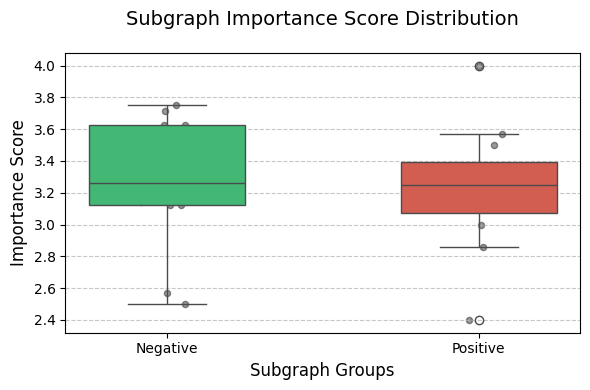

Statistic: 0.35208939510976517, p-value: 0.362385610653095


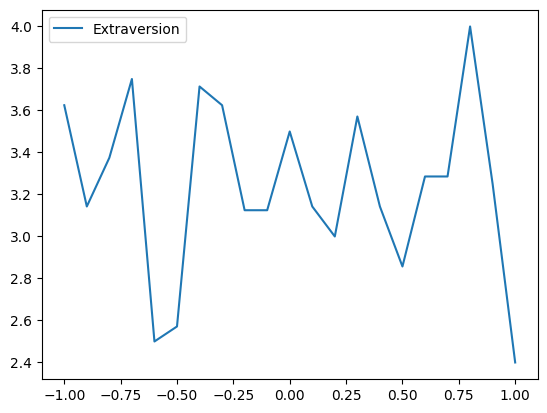

In [11]:
statistic, pvalue = plot_importance_distribution(results["Extraversion"])
print(f"Statistic: {statistic}, p-value: {pvalue}")

# for trait, res in results.items():
#     plt.plot(coeffs, res, label=trait)

plt.plot(coeffs, results["Extraversion"], label="Extraversion")
    
plt.legend()
plt.show()